# A hands-on introduction to querying evolutionary relationships across multiple data sources using SPARQL

## Accompanying Jupyter Notebook for tutorial

# Protocol 1. Retrieve pairwise orthologs (EBI, OMA, MBGD)

In [194]:
# first we need to define the SPARQL endpoints of each source, to use later in the protocols
import sys
!{sys.executable} -m pip install SPARQLWrapper
from SPARQLWrapper import SPARQLWrapper, JSON
import sys, os, time
import pandas as pd

# always display full column results (don't truncate output)
pd.set_option('display.max_colwidth', -1)

# the endpoints must be defined as wrappers for executing SPARQL queries
sparql_OMA = SPARQLWrapper("https://sparql.omabrowser.org/sparql")
sparql_MBGD = SPARQLWrapper("http://sparql.nibb.ac.jp/sparql")
sparql_EBI = SPARQLWrapper("https://www.ebi.ac.uk/rdf/services/sparql")
sparql_OrthoDB = SPARQLWrapper("https://sparql.orthodb.org/sparql")


# function to print in a table results of a SPARQL query
def pretty_print(results):
    
    # how to transform SPARQL results into Pandas dataframes
    
    # get header (column names) from results
    header = results["results"]["bindings"][0].keys()

    # display table of results:
    table = []
    
    # the SPARQL JSON results to the query are available in the "results", "bindings" entry:
    for entry in results["results"]["bindings"]:
        # append entries from the results to a regular Python list of rows, which we can then transform to a Pandas DF
        row = [entry[column]["value"] if entry.get(column, None) != None else None for column in header]
        table.append(row)
    df = pd.DataFrame(table, columns=list(header))
    return df



You should consider upgrading via the 'pip install --upgrade pip' command.


## UniProt URI used throughout tutorial 

In [195]:
# (here, we use the HBB human gene, https://www.uniprot.org/uniprot/P68871)
# to experiment with other entries, simply change the accession number P68871 to the one of interest from UniProt
# then execute the code fragments below

uniprot_entry = "http://purl.uniprot.org/uniprot/P68871"

# the following variable defines how many entries to retrieve from the sources:
# e.g. here, we only print 3 example entries (leave empty to show all results)

NUM_EXAMPLES=3

## a) EBI pairwise orthologs

In [ ]:
# Code Fragment 2 from Tutorial
# here displaying also the gene name and the species name for the ortholog genes

query_EBI_pairwise = """
    PREFIX obo: <http://purl.obolibrary.org/obo/>
    PREFIX sio: <http://semanticscience.org/resource/>
    PREFIX ensembl: <http://rdf.ebi.ac.uk/resource/ensembl/>
    PREFIX ensemblterms: <http://rdf.ebi.ac.uk/terms/ensembl/>

    SELECT DISTINCT ?gene_uniprot_uri ?ortholog_uniprot_uri ?orthologLabel ?species_name {
      VALUES(?gene_uniprot_uri){(<"""+ uniprot_entry + """>)}

      ?gene sio:SIO_000558 ?ortholog .
      ?gene obo:RO_0002162 ?taxon .
      ?ortholog obo:RO_0002162 ?ortholog_taxon .
      ?ortholog ensemblterms:DEPENDENT ?ortholog_uniprot_uri .
      ?ortholog rdfs:label ?orthologLabel .
      ?ortholog obo:RO_0002162 ?ortholog_taxon .
      ?ortholog_taxon skos:altLabel ?species_name
      ?gene ensemblterms:DEPENDENT  ?gene_uniprot_uri.
      FILTER(?taxon != ?ortholog_taxon 
                 && 
            STRSTARTS(STR(?ortholog_uniprot_uri),"http://purl.uniprot.org/uniprot/"))
    }

"""

In [ ]:
# set the query to be executed against the EBI endpoint and set the return format to JSON
sparql_EBI.setQuery(query_EBI_pairwise)
sparql_EBI.setReturnFormat(JSON)

results_EBI = sparql_EBI.query().convert()

pretty_print(results_EBI).head(NUM_EXAMPLES)

## b) OMA pairwise orthologs

In [198]:
# Code Fragment 4 from Tutorial

query_OMA_pairwise = """
    PREFIX oma: <http://omabrowser.org/ontology/oma#>
    PREFIX orth: <http://purl.org/net/orth#>
    PREFIX sio: <http://semanticscience.org/resource/>
    PREFIX lscr: <http://purl.org/lscr#>

    SELECT DISTINCT ?protein1 ?protein2 {
        VALUES(?protein1){(<"""+ uniprot_entry + """>)}

        ?cluster a orth:OrthologsCluster.
        ?cluster orth:hasHomologousMember ?node1.
        ?cluster orth:hasHomologousMember ?node2.
        ?node2 orth:hasHomologousMember* ?protein_OMA_2.
        ?node1 orth:hasHomologousMember* ?protein_OMA_1. 
        ?protein_OMA_2  lscr:xrefUniprot ?protein2. 
        ?protein_OMA_1  lscr:xrefUniprot ?protein1.
        # ensuring that ?protein_OMA_1 and ?protein_OMA_2 are not members of the same (paralogs) cluster
        FILTER(?node1 != ?node2) 
    }
"""

In [199]:
# set the query to be executed against the OMA endpoint and set the return format to JSON
sparql_OMA.setQuery(query_OMA_pairwise)
sparql_OMA.setReturnFormat(JSON)

results_OMA = sparql_OMA.query().convert()

pretty_print(results_OMA).head(NUM_EXAMPLES)

,protein1,protein2
0,http://purl.uniprot.org/uniprot/P68871,http://purl.uniprot.org/uniprot/B3F9V5
1,http://purl.uniprot.org/uniprot/P68871,http://purl.uniprot.org/uniprot/C8YNR1
2,http://purl.uniprot.org/uniprot/P68871,http://purl.uniprot.org/uniprot/B3F9D4


## c) MBGD pairwise orthologs

In [200]:
# Code Fragment 5 from tutorial
query_MBGD_pairwise = """
    PREFIX mbgdr: <http://mbgd.genome.ad.jp/rdf/resource/>
    PREFIX mbgd: <http://purl.jp/bio/11/mbgd#>
    PREFIX orth: <http://purl.org/net/orth#>

    SELECT DISTINCT ?protein1 ?protein2 
    WHERE {
        VALUES(?protein1){ (<"""+ uniprot_entry + """>)}

        ?cluster a orth:OrthologsCluster.
        ?cluster orth:hasHomologous ?node1.
        ?cluster orth:hasHomologous ?node2.
        ?node2 orth:hasHomologous* ?gene2.
        ?node1 orth:hasHomologous* ?gene1.
        ?gene1 mbgd:uniprot ?protein1.
        ?gene2 mbgd:uniprot ?protein2.
        FILTER(?node1 != ?node2) # ensuring that ?gene1 and ?gene2 are not members of the same paralogs cluster
    } 
"""

In [201]:
# set the query to be executed against the MBGD endpoint and set the return format to JSON
sparql_MBGD.setQuery(query_MBGD_pairwise)
sparql_MBGD.setReturnFormat(JSON)

results_MBGD = sparql_MBGD.query().convert()

pretty_print(results_MBGD).head(NUM_EXAMPLES)

,protein1,protein2
0,http://purl.uniprot.org/uniprot/P68871,http://purl.uniprot.org/uniprot/O17824
1,http://purl.uniprot.org/uniprot/P68871,http://purl.uniprot.org/uniprot/B3GWE1
2,http://purl.uniprot.org/uniprot/P68871,http://purl.uniprot.org/uniprot/D9YZU8


# Protocol 2. Retrieve homologous groups

### a) OMA Homologous Groups derived from the HOGs 

In [202]:
query_OMA_HomGroups = """
PREFIX lscr: <http://purl.org/lscr#>
PREFIX orth: <http://purl.org/net/orth#>

SELECT DISTINCT ?cluster ?protein2_OMA_URI ?protein2_uniprot_URI ?tax_name {
    VALUES(?protein1_uniprot_URI){(<http://purl.uniprot.org/uniprot/P68871>)}
    VALUES(?tax_name){("Primates")}

    ?cluster a orth:OrthologsCluster.
    ?cluster orth:hasHomologousMember* ?protein_OMA_1.
    ?cluster orth:hasHomologousMember* ?protein2_OMA_URI. 
    ?protein_OMA_1 a orth:Protein.
    ?protein2_OMA_URI a orth:Protein.
    ?protein_OMA_1  lscr:xrefUniprot ?protein1_uniprot_URI.
    OPTIONAL{?protein2_OMA_URI  lscr:xrefUniprot ?protein2_uniprot_URI.}
    ?cluster orth:hasTaxonomicRange ?tax.
    ?tax  orth:taxRange ?tax_name. 
} 
"""

In [203]:
sparql_OMA.setQuery(query_OMA_HomGroups)
sparql_OMA.setReturnFormat(JSON)

results_OMA = sparql_OMA.query().convert()

pretty_print(results_OMA).head(NUM_EXAMPLES)

,cluster,protein2_OMA_URI,protein2_uniprot_URI,tax_name
0,http://omabrowser.org/ontology/oma#GROUP_425283_Primates_136,https://omabrowser.org/oma/info/NOMLE01423,http://purl.uniprot.org/uniprot/G1S6C3,Primates
1,http://omabrowser.org/ontology/oma#GROUP_425283_Primates_136,https://omabrowser.org/oma/info/NOMLE01424,http://purl.uniprot.org/uniprot/G1S6C6,Primates
2,http://omabrowser.org/ontology/oma#GROUP_425283_Primates_136,https://omabrowser.org/oma/info/HUMAN04027,http://purl.uniprot.org/uniprot/D9YZU5,Primates


### b) MBGD Homologous Groups derived from the HOGs

In [204]:
query_MBGD_HomGroups = """
PREFIX mbgdr: <http://mbgd.genome.ad.jp/rdf/resource/>
PREFIX mbgd: <http://purl.jp/bio/11/mbgd#>
PREFIX orth: <http://purl.org/net/orth#>
 
 
SELECT DISTINCT ?hog ?gene1_uniprot (?gene1 as ?gene1_MBGD) ?taxLevel_uniprot {
   VALUES ?protein2_uniprot {<http://purl.uniprot.org/uniprot/B8GA25>}
   
   ?hog a orth:OrthologsCluster.
   ?hog orth:hasHomologous+ ?node1.
   ?node1 orth:hasHomologous* ?gene1.
   ?hog orth:hasHomologous* ?gene2.
   ?gene1 a orth:Gene.
   OPTIONAL {?gene1 mbgd:uniprot ?gene1_uniprot}.
   
   ?gene2 a orth:Gene.
   ?gene2  mbgd:uniprot ?protein2_uniprot.
 
   # extracting taxonomic range from the cluster IRI is non-trivial, but can be achieved through the following:
   # an example ?node1 IRI is: cluster-id:2018-01_tax32_8537, the taxonomic level we want to extract is 32 
   BIND(IF(CONTAINS(STR(?node1),"cluster"), 
     IRI(CONCAT("http://purl.uniprot.org/taxonomy/", STRBEFORE(STRAFTER(STR(?node1),"_tax"),"_")) ), 0) as ?taxLevel_uniprot)

   FILTER not exists{?x orth:hasHomologous ?hog}
} ORDER BY ?taxLevel_uniprot

"""

In [205]:
sparql_MBGD.setQuery(query_MBGD_HomGroups)
sparql_MBGD.setReturnFormat(JSON)

results_MBGD = sparql_MBGD.query().convert()
    
pretty_print(results_MBGD).head(NUM_EXAMPLES)

,hog,gene1_uniprot,gene1_MBGD,taxLevel_uniprot
0,http://mbgd.genome.ad.jp/rdf/resource/cluster/2018-01_default_3927,http://purl.uniprot.org/uniprot/K9Z5P0,http://mbgd.genome.ad.jp/rdf/resource/gene/can:CYAN10605_RS04175,http://purl.uniprot.org/taxonomy/102234
1,http://mbgd.genome.ad.jp/rdf/resource/cluster/2018-01_default_3927,http://purl.uniprot.org/uniprot/K9Z5R1,http://mbgd.genome.ad.jp/rdf/resource/gene/can:CYAN10605_RS09030,http://purl.uniprot.org/taxonomy/102234
2,http://mbgd.genome.ad.jp/rdf/resource/cluster/2018-01_default_3927,http://purl.uniprot.org/uniprot/K9Z6U5,http://mbgd.genome.ad.jp/rdf/resource/gene/can:CYAN10605_RS10950,http://purl.uniprot.org/taxonomy/102234


### c) OrthoDB Homologous Groups

In [206]:
query_OrthoDB_HomGroups = """
PREFIX orthodb: <http://purl.orthodb.org/>
PREFIX up: <http://purl.uniprot.org/core/>

SELECT DISTINCT ?groups ?species_name ?protein1_uniprot ?gene1 ?taxLevel_uniprot ?taxLevel WHERE {
    VALUES ?protein2_uniprot {<http://purl.uniprot.org/uniprot/P68871>}
    VALUES ?taxLevel {"Primates"}

    ?gene2 a orthodb:Gene. 
    ?gene2 orthodb:memberOf ?groups.
    ?gene1 a orthodb:Gene.
    ?gene1 orthodb:memberOf ?groups.
    ?gene1 up:organism ?organism. 
    ?organism a ?taxon.
    ?taxon up:scientificName ?species_name.
    ?groups orthodb:ogBuiltAt ?taxLevel_uniprot . 
    ?taxLevel_uniprot up:scientificName ?taxLevel.
    ?gene2 orthodb:xref ?xref2. 
    ?xref2 orthodb:xrefResource ?protein2_uniprot .
    ?protein2_uniprot  a orthodb:Uniprot.
    ?gene1 orthodb:xref ?xref. 
    ?xref a orthodb:Xref. 
    OPTIONAL{
     ?xref orthodb:xrefResource ?protein1_uniprot .
     ?protein1_uniprot  a orthodb:Uniprot.}
    } ORDER BY ?groups, ?taxLevel
"""

In [207]:
sparql_OrthoDB.setQuery(query_OrthoDB_HomGroups)
sparql_OrthoDB.setReturnFormat(JSON)

results_OrthoDB = sparql_OrthoDB.query().convert()

pretty_print(results_OrthoDB).head(NUM_EXAMPLES)

,groups,species_name,protein1_uniprot,gene1,taxLevel_uniprot,taxLevel
0,http://purl.orthodb.org/odbgroup/46208at9443,Saimiri boliviensis boliviensis,http://purl.uniprot.org/uniprot/A0A2K6S1A6,http://purl.orthodb.org/odbgene/39432_0_000bcd,http://purl.uniprot.org/taxonomy/9443,Primates
1,http://purl.orthodb.org/odbgroup/46208at9443,Saimiri boliviensis boliviensis,http://purl.uniprot.org/uniprot/A0A2K6U507,http://purl.orthodb.org/odbgene/39432_0_000c78,http://purl.uniprot.org/taxonomy/9443,Primates
2,http://purl.orthodb.org/odbgroup/46208at9443,Carlito syrichta,http://purl.uniprot.org/uniprot/A0A1U7TAR4,http://purl.orthodb.org/odbgene/1868482_0_001552,http://purl.uniprot.org/taxonomy/9443,Primates


# Protocol 3. Retrieve Hierachical Orthologous Groups (HOGs)

### a) Retrieving HOGs from OMA 

In [208]:
query_OMA_HOGs = """
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX orth: <http://purl.org/net/orth#>
PREFIX taxon: <http://purl.uniprot.org/taxonomy/>
PREFIX up: <http://purl.uniprot.org/core/>
PREFIX lscr: <http://purl.org/lscr#>

SELECT DISTINCT ?root_hog ?species_name ?protein1_uniprot (?protein1 as 
           ?protein1_OMA) ?taxLevel  {
	VALUES ?protein2_uniprot {<http://purl.uniprot.org/uniprot/P68871>}
	?root_hog obo:CDAO_0000148 ?hog_cluster. #has_Root
	?hog_cluster orth:hasHomologousMember* ?node1.
	?node1 a orth:OrthologsCluster.
	?node1 orth:hasTaxonomicRange ?level.
	?level orth:taxRange ?taxLevel .
	?node1 orth:hasHomologousMember* ?protein1.
	?hog_cluster orth:hasHomologousMember* ?protein2.
	?protein1 a orth:Protein.
    	?protein1 orth:organism ?organism.
    	?organism obo:RO_0002162 ?taxon.
    	?taxon up:scientificName ?species_name.
	OPTIONAL {?protein1 lscr:xrefUniprot ?protein1_uniprot}. 
	?protein2 a orth:Protein. 
	?protein2  lscr:xrefUniprot ?protein2_uniprot. 
} ORDER BY ?taxLevel

"""

In [209]:
sparql_OMA.setQuery(query_OMA_HOGs)
sparql_OMA.setReturnFormat(JSON)

results_OMA = sparql_OMA.query().convert()

pretty_print(results_OMA).head(NUM_EXAMPLES)

,root_hog,species_name,protein1_uniprot,protein1_OMA,taxLevel
0,http://omabrowser.org/ontology/oma#HOG_425283,Gadus morhua,http://purl.uniprot.org/uniprot/B3F9V5,https://omabrowser.org/oma/info/GADMO00980,Acanthomorphata
1,http://omabrowser.org/ontology/oma#HOG_425283,Gadus morhua,http://purl.uniprot.org/uniprot/C8YNR1,https://omabrowser.org/oma/info/GADMO00981,Acanthomorphata
2,http://omabrowser.org/ontology/oma#HOG_425283,Gadus morhua,http://purl.uniprot.org/uniprot/B3F9D4,https://omabrowser.org/oma/info/GADMO00981,Acanthomorphata


### b)	Retrieving HOGs from MBGD

In [210]:
query_MBGD_HOGs = """
PREFIX mbgdr: <http://mbgd.genome.ad.jp/rdf/resource/>
PREFIX mbgd: <http://purl.jp/bio/11/mbgd#>
PREFIX orth: <http://purl.org/net/orth#>


SELECT DISTINCT ?hog ?gene1_uniprot (?gene1 as 
           ?gene1_MBGD) ?taxLevel_uniprot {
	VALUES ?protein2_uniprot {<http://purl.uniprot.org/uniprot/B8GA25>}
       ?hog a orth:OrthologsCluster.
	?hog orth:hasHomologous+ ?node1.
       ?node1 orth:hasHomologous* ?gene1.
	?hog orth:hasHomologous* ?gene2.
	?gene1 a orth:Gene.
	OPTIONAL{?gene1 mbgd:uniprot ?gene1_uniprot}.
       ?gene2 a orth:Gene.
	?gene2  mbgd:uniprot ?protein2_uniprot. 

BIND(IF(CONTAINS(STR(?node1),"cluster"), IRI(CONCAT("http://purl.uniprot.org/taxonomy/",STRBEFORE(STRAFTER(STR(?node1),"_tax"),"_")) ), 0) as ?taxLevel_uniprot)
FILTER not exists{?x orth:hasHomologous ?hog}
} ORDER BY ?taxLevel_uniprot

"""

In [211]:
sparql_MBGD.setQuery(query_MBGD_HOGs)
sparql_MBGD.setReturnFormat(JSON)

results_MBGD = sparql_MBGD.query().convert()

pretty_print(results_MBGD).head(NUM_EXAMPLES)

,hog,gene1_uniprot,gene1_MBGD,taxLevel_uniprot
0,http://mbgd.genome.ad.jp/rdf/resource/cluster/2018-01_default_3927,http://purl.uniprot.org/uniprot/K9Z5P0,http://mbgd.genome.ad.jp/rdf/resource/gene/can:CYAN10605_RS04175,http://purl.uniprot.org/taxonomy/102234
1,http://mbgd.genome.ad.jp/rdf/resource/cluster/2018-01_default_3927,http://purl.uniprot.org/uniprot/K9Z5R1,http://mbgd.genome.ad.jp/rdf/resource/gene/can:CYAN10605_RS09030,http://purl.uniprot.org/taxonomy/102234
2,http://mbgd.genome.ad.jp/rdf/resource/cluster/2018-01_default_3927,http://purl.uniprot.org/uniprot/K9Z6U5,http://mbgd.genome.ad.jp/rdf/resource/gene/can:CYAN10605_RS10950,http://purl.uniprot.org/taxonomy/102234


### c) Retrieving HOGs from OrthoDB

In [212]:
query_OrthoDB_HOGs = """
PREFIX orthodb: <http://purl.orthodb.org/>
PREFIX up: <http://purl.uniprot.org/core/>

SELECT DISTINCT ?hog_root ?species_name ?protein1_uniprot ?gene1 ?taxLevel_uniprot ?taxLevel 
WHERE {
     VALUES ?protein2_uniprot {<http://purl.uniprot.org/uniprot/P68871>}
     ?gene2 a orthodb:Gene. 
     ?gene2 orthodb:memberOf ?groups.
     ?gene2 orthodb:memberOf ?hog_root.
     FILTER NOT EXISTS {?hog_root  orthodb:ancestralOG ?ancestor.}
     
     ?groups orthodb:ancestralOG* ?hog_root.
     ?groups orthodb:ogBuiltAt ?taxLevel_uniprot . 
     ?taxLevel_uniprot up:scientificName ?taxLevel.
     
     ?gene1 a orthodb:Gene. 
     ?gene1 orthodb:memberOf ?groups.
     ?gene1 up:organism ?organism. 
     ?organism a ?taxon.
     ?taxon up:scientificName ?species_name.
     ?gene2 orthodb:xref ?xref2 . 
     ?xref2 orthodb:xrefResource ?protein2_uniprot .
     ?protein2_uniprot  a orthodb:Uniprot.
     ?gene1 orthodb:xref ?xref.
     ?xref orthodb:xrefResource ?protein1_uniprot.
     ?protein1_uniprot  a orthodb:Uniprot.
} ORDER BY ?hog_root, ?taxLevel
"""

In [213]:
sparql_OrthoDB.setQuery(query_OrthoDB_HOGs)
sparql_OrthoDB.setReturnFormat(JSON)

results_OrthoDB = sparql_OrthoDB.query().convert()
pretty_print(results_OrthoDB).head(NUM_EXAMPLES)

,hog_root,species_name,protein1_uniprot,gene1,taxLevel_uniprot,taxLevel
0,http://purl.orthodb.org/odbgroup/1370439at2759,Dipodomys ordii,http://purl.uniprot.org/uniprot/A0A1S3EYZ7,http://purl.orthodb.org/odbgene/10020_0_0014c2,http://purl.uniprot.org/taxonomy/2759,Eukaryota
1,http://purl.orthodb.org/odbgroup/1370439at2759,Cricetulus griseus,http://purl.uniprot.org/uniprot/A0A061IB11,http://purl.orthodb.org/odbgene/10029_0_0042fb,http://purl.uniprot.org/taxonomy/2759,Eukaryota
2,http://purl.orthodb.org/odbgroup/1370439at2759,Cricetulus griseus,http://purl.uniprot.org/uniprot/G3IF93,http://purl.orthodb.org/odbgene/10029_0_004651,http://purl.uniprot.org/taxonomy/2759,Eukaryota


# Protocol 4. Meta-analysis - comparing data across OMA and MBGD orthology

In [214]:
# find all orthologs for the psb27 gene (UniProt RDF URI http://purl.uniprot.org/uniprot/K9Z723) 
# that are present in MBGD, but are NOT orthologs for this gene according to information in OMA

federated_query_MBGD_OMA = """
PREFIX oma: <http://omabrowser.org/ontology/oma#>
PREFIX orth: <http://purl.org/net/orth#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX lscr: <http://purl.org/lscr#>
PREFIX mbgd: <http://purl.jp/bio/11/mbgd#>

SELECT ?protein2 ?species WHERE {

  # get all pairwise orthologs of the psb27 gene from MBGD (same as in Protocol 1 c)
  
  SERVICE <http://sparql.nibb.ac.jp/sparql> {
    SELECT ?protein2 ?species where {
		?cluster_mbgd a orth:OrthologsCluster.
		?cluster_mbgd orth:hasHomologous ?node1_mbgd.
		?cluster_mbgd orth:hasHomologous ?node2_mbgd.
             ?node1_mbgd orth:hasHomologous* ?gene1.
		?node2_mbgd orth:hasHomologous* ?gene2.
		?gene1 mbgd:uniprot <http://purl.uniprot.org/uniprot/K9Z723>.
		?gene2 mbgd:uniprot ?protein2.
           	?gene2 mbgd:organism ?taxon.
             OPTIONAL{?taxon mbgd:species ?species.}
		FILTER(?node1_mbgd != ?node2_mbgd)  } }

    # keep only those that do not exist in OMA (using the code in Protocol 1 b)
    
    FILTER NOT EXISTS {                      
        ?cluster a orth:OrthologsCluster.
        ?cluster orth:hasHomologousMember ?node1.
        ?cluster orth:hasHomologousMember ?node2.
        ?node1 orth:hasHomologousMember* ?protein_OMA_1. 
        ?node2 orth:hasHomologousMember* ?protein_OMA_2.
        ?protein_OMA_1  lscr:xrefUniprot <http://purl.uniprot.org/uniprot/K9Z723>.
        ?protein_OMA_2  lscr:xrefUniprot ?protein2.
        FILTER(?node1 != ?node2) 
    }
 }
"""

In [215]:
# execute the federated query of the OMA SPARQL endpoint

sparql_OMA.setQuery(federated_query_MBGD_OMA)
sparql_OMA.setReturnFormat(JSON)

results_OMA = sparql_OMA.query().convert()

# here we print all results by commenting out the "head" command
pretty_print(results_OMA)#.head(NUM_EXAMPLES)

,protein2,species
0,http://purl.uniprot.org/uniprot/K9TZ64,Chroococcidiopsis thermalis
1,http://purl.uniprot.org/uniprot/K9YX74,Dactylococcopsis salina
2,http://purl.uniprot.org/uniprot/A0A163CGL5,Prochlorococcus marinus
3,http://purl.uniprot.org/uniprot/A0A163UA12,Prochlorococcus marinus
4,http://purl.uniprot.org/uniprot/A0A0H5PT34,Synechococcus sp. WH 8102
5,http://purl.uniprot.org/uniprot/K9X1C4,Cylindrospermum stagnale
6,http://purl.uniprot.org/uniprot/K9S4Q8,Geitlerinema sp. PCC 7407
7,http://purl.uniprot.org/uniprot/K9XDR7,Gloeocapsa sp. PCC 7428
8,http://purl.uniprot.org/uniprot/K7W341,Anabaena sp. 90
9,http://purl.uniprot.org/uniprot/L8ASA1,Bacillus subtilis


# Aggregations in SPARQL

## Get top 10 entries with most orthologs for a given species, e.g. Drosophila Melanogaster - in OMA and MBGD

## a) OMA

In [216]:
query_OMA_Top10EntriesWithMostOrthologs_Drosophila = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX oma: <http://omabrowser.org/ontology/oma#>
PREFIX orth: <http://purl.org/net/orth#>
PREFIX taxon: <http://purl.uniprot.org/taxonomy/>
PREFIX up: <http://purl.uniprot.org/core/>

select ?PROTEIN (count(distinct ?IS_ORTHO_TO_PROTEIN) as ?num_orthologs ) 
    where { 
       ?cluster a orth:OrthologsCluster. 
       ?cluster orth:hasHomologousMember ?node1. 
       ?cluster orth:hasHomologousMember ?node2.  
       ?node1 orth:hasHomologousMember* ?IS_ORTHO_TO_PROTEIN. 
       ?node2 orth:hasHomologousMember* ?PROTEIN. 
       ?PROTEIN a orth:Protein. 
       ?PROTEIN orth:organism/obo:RO_0002162/up:scientificName ?species. 
       ?IS_ORTHO_TO_PROTEIN a orth:Protein. 
       ?IS_ORTHO_TO_PROTEIN orth:organism/obo:RO_0002162/up:scientificName ?other_species . 
       values(?species){( 'Drosophila melanogaster' )} 
       filter(?node1 != ?node2) 
   } group by ?PROTEIN order by DESC(?num_orthologs) limit 10

"""

In [217]:
sparql_OMA.setQuery(query_OMA_Top10EntriesWithMostOrthologs_Drosophila)
sparql_OMA.setReturnFormat(JSON)

results_OMA = sparql_OMA.query().convert()

pretty_print(results_OMA).head(NUM_EXAMPLES)

,PROTEIN,num_orthologs
0,https://omabrowser.org/oma/info/DROME02601,59215
1,https://omabrowser.org/oma/info/DROME16727,59206
2,https://omabrowser.org/oma/info/DROME03895,59195


## b) MBGD - Note: This may take a while...

In [218]:
query_MBGD_Top10EntriesWithMostOrthologs_Drosophila = """
PREFIX orth: <http://purl.org/net/orth#>
PREFIX mbgd: <http://purl.jp/bio/11/mbgd#>
PREFIX taxon: <http://ddbj.nig.ac.jp/ontologies/taxonomy/>

select ?GENE (count(distinct ?IS_ORTHO_TO_GENE) as ?num_orthologs ) 
    where { 
       ?cluster a orth:OrthologsCluster. 
       ?cluster orth:hasHomologous ?node1. 
       ?cluster orth:hasHomologous ?node2.  
       ?node1 orth:hasHomologous* ?IS_ORTHO_TO_GENE. 
       ?node2 orth:hasHomologous* ?GENE.  
       ?GENE a orth:Gene. 
       ?GENE mbgd:organism/mbgd:inTaxon/taxon:scientificName ?species. 
       ?IS_ORTHO_TO_GENE a orth:Gene. 
       ?IS_ORTHO_TO_GENE mbgd:organism/mbgd:inTaxon/taxon:scientificName ?other_species . 
       values(?species){( 'Drosophila melanogaster' )} 
       filter(?node1 != ?node2) 
   } group by ?GENE order by DESC(?num_orthologs) limit 10
"""

In [219]:
sparql_MBGD.setQuery(query_MBGD_Top10EntriesWithMostOrthologs_Drosophila)
sparql_MBGD.setReturnFormat(JSON)

results_MBGD = sparql_MBGD.query().convert()

pretty_print(results_MBGD).head(NUM_EXAMPLES)

,GENE,num_orthologs
0,http://mbgd.genome.ad.jp/rdf/resource/gene/dme:DMEL_CG11147,404037
1,http://mbgd.genome.ad.jp/rdf/resource/gene/dme:DMEL_CG33970,404037
2,http://mbgd.genome.ad.jp/rdf/resource/gene/dme:DMEL_CG9990,404037


## Bonus: Histogram of number of entries per species in OMA and MBGD

In [220]:
# histogram OMA - how many entries per taxon? which are the taxa with most entries?
group_by_OMA_species = """ 
    PREFIX obo:<http://purl.obolibrary.org/obo/>
    PREFIX orth: <http://purl.org/net/orth#>
    PREFIX up: <http://purl.uniprot.org/core/>
    select (count(distinct ?protein) as ?count) ?taxon ?name
    where {
        ?protein a orth:Protein.
        ?protein orth:organism/obo:RO_0002162 ?taxon.
        ?taxon up:scientificName ?name.
    } group by ?taxon ?name order by desc(?count)
"""

In [221]:
# count number of proteins/clusters for each taxonomic range

group_by_taxRange_OMA = """
    PREFIX lscr: <http://purl.org/lscr#>
    PREFIX orth: <http://purl.org/net/orth#>

    SELECT (count(distinct ?cluster) as ?count) ?tax ?name {
        ?cluster a orth:OrthologsCluster.
        ?cluster orth:hasTaxonomicRange ?tax.
        ?tax  orth:taxRange ?name.
    } group by ?tax ?name order by desc(?count)
"""

In [222]:
sparql_OMA.setQuery(group_by_taxRange_OMA)
sparql_OMA.setReturnFormat(JSON)

results_OMA = sparql_OMA.query().convert()

print("Number of distinct tax range in OMA: "+ str(len(results_OMA["results"]["bindings"])))

Number of distinct tax range in OMA: 975


In [223]:
sparql_OMA.setQuery(group_by_OMA)
sparql_OMA.setReturnFormat(JSON)

results_OMA = sparql_OMA.query().convert()

print("Number of distinct taxa in OMA: "+ str(len(results_OMA["results"]["bindings"])))

Number of distinct taxa in OMA: 2288


In [224]:
# prepare dictionary based on data (either using taxon URI or taxon scientific name)
group_by_results_OMA = {}
for entry in results_OMA["results"]["bindings"]:
    #group_by_results[entry["taxon"]["value"]] = int(entry["count"]["value"])
    group_by_results_OMA[entry["name"]["value"]] = int(entry["count"]["value"])
 

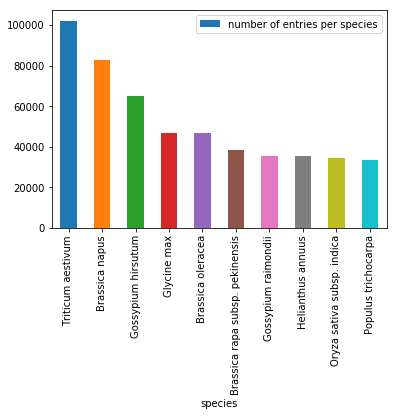

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# how many species to show on plot
NUM_SPECIES = 10
df_groupBy = pd.DataFrame(list(group_by_results_OMA.items()), columns=['species', 'number of entries per species'])[:NUM_SPECIES]
df_groupBy.plot(kind='bar',x='species',y='number of entries per species')

## b) MBGD - Note: This may take a while...

In [226]:
# histogram MGDB
group_by_MGDB_species = """ 
    PREFIX orth: <http://purl.org/net/orth#>
    PREFIX mbgd: <http://purl.jp/bio/11/mbgd#> 
    PREFIX ddbj: <http://ddbj.nig.ac.jp/ontologies/taxonomy/>
    select (count(distinct ?gene) as ?count) ?taxon ?name
    where {
        ?gene a orth:Gene.
        ?gene mbgd:organism/mbgd:inTaxon ?taxon.
        ?taxon ddbj:scientificName ?name.
        ?taxon ddbj:rank ddbj:Species.
    } group by ?taxon ?name order by desc(?count)
"""

In [ ]:
# prepare dictionary based on data (either using taxon URI or taxon scientific name)
sparql_MBGD.setQuery(group_by_MGDB_species)
sparql_MBGD.setReturnFormat(JSON)

results_MBGD = sparql_MBGD.query().convert()

print("Number of distinct species in MBGD: "+ str(len(results_MBGD["results"]["bindings"])))
group_by_results_MBGD = {}
for entry in results_MBGD["results"]["bindings"]:
    group_by_results_MBGD[entry["name"]["value"]] = int(entry["count"]["value"])
 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df_groupBy = pd.DataFrame(list(group_by_results_MBGD.items()), columns=['species', 'number of entries per species'])[:NUM_SPECIES]
df_groupBy.plot(kind='bar',x='species',y='number of entries per species')

In [ ]:
# VARIANT: GROUP BY SUPERKINGDOM / Phylum

group_by_MGDB_superkingdom_phylum = """
PREFIX obo:<http://purl.obolibrary.org/obo/>
PREFIX orth: <http://purl.org/net/orth#>
PREFIX mbgdr: <http://mbgd.genome.ad.jp/rdf/resource/>
PREFIX mbgd: <http://purl.jp/bio/11/mbgd#>

select (count(distinct ?gene) as ?count) ?superkingdom ?phylum
where {
  ?gene a orth:Gene ;
      mbgd:organism ?org .
  ?org mbgd:inSuperkingdom/rdfs:label ?superkingdom .
  OPTIONAL {
		?org mbgd:inPhylum/rdfs:label ?phylum .
  }
 }
 group BY ?superkingdom ?phylum order by desc(?count)
"""

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sparql_MBGD.setQuery(group_by_MGDB_superkingdom_phylum)
sparql_MBGD.setReturnFormat(JSON)

results_MBGD = sparql_MBGD.query().convert()

group_by_results_MBGD = {}
for entry in results_MBGD["results"]["bindings"]:
    group_by_results_MBGD[entry["name"]["value"]] = int(entry["count"]["value"])
df_groupBy = pd.DataFrame(list(group_by_results_MBGD.items()), columns=['phylum', 'count'])
df_groupBy.plot(kind='bar',x='phylum',y='count')